## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import config as c
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from image_colorization.models import MainModel
from image_colorization.dataset import make_dataloaders
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm
import time
from models import PatchDiscriminator
from utils import create_loss_meters, update_losses, log_results, visualize

## Set global parameters

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## Load data

In [4]:
import config as c
# load train data from c.TRAIN_ANAGLYPH_FILE
train_anaglyphs_paths = open(c.TRAIN_ANAGLYPH_FILE, 'r').read().splitlines()
train_reversed_paths = open(c.TRAIN_REVERSED_FILE, 'r').read().splitlines()

# load val data from c.VALIDATION_ANAGLYPH_FILE
val_anaglyphs_paths = open(c.VALIDATION_ANAGLYPH_FILE, 'r').read().splitlines()
val_reversed_paths = open(c.VALIDATION_REVERSED_FILE, 'r').read().splitlines()

# load test data from c.TEST_ANAGLYPH_FILE
test_anaglyphs_paths = open(c.TEST_ANAGLYPH_FILE, 'r').read().splitlines()
test_reversed_paths = open(c.TEST_REVERSED_FILE, 'r').read().splitlines()


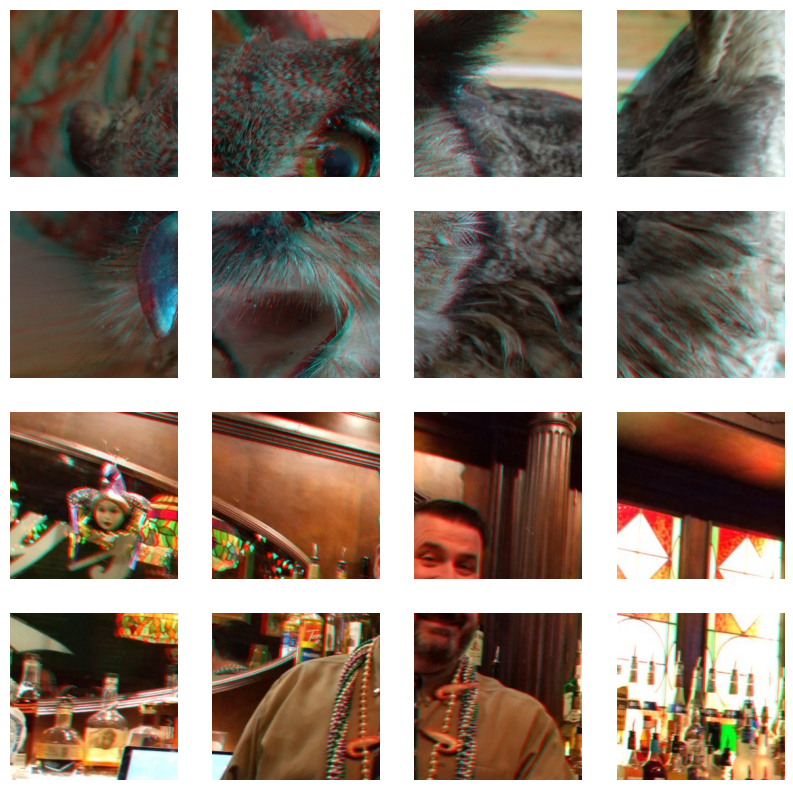

In [5]:
_, axes = plt.subplots(4, 4, figsize=(10, 10))
for ax, img_path in zip(axes.flatten(), train_anaglyphs_paths):
    ax.imshow(Image.open(img_path))
    ax.axis("off")

In [6]:
# create dataloaders
train_dl = make_dataloaders(path_anaglyph=train_anaglyphs_paths, path_reversed=train_reversed_paths, split='train')
val_dl = make_dataloaders(path_anaglyph=val_anaglyphs_paths, path_reversed=val_reversed_paths, split='val')

In [9]:
# check the shape of the data
data = next(iter(train_dl))
Ls, abs_ = data['L_a'], data['ab_a']
print(Ls.shape, abs_.shape)
print(len(train_dl), len(val_dl))

torch.Size([16, 1, 256, 256]) torch.Size([16, 2, 256, 256])
28 7


## Discriminator

In [10]:
# See discriminator blocks
PatchDiscriminator(3)

PatchDiscriminator(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (

In [11]:
# discriminator shape
discriminator = PatchDiscriminator(3)
dummy_input = torch.randn(16, 3, 256, 256) # batch_size, channels, size, size
out = discriminator(dummy_input)
out.shape

torch.Size([16, 1, 30, 30])

## Training function

In [12]:
def train_model(model, train_dl, epochs, display_every=200):
    data = next(iter(val_dl)) # getting a batch for visualizing the model output after fixed intervals
    for e in range(epochs):
        loss_meter_dict = create_loss_meters() # function returing a dictionary of objects to
        i = 0                                  # log the losses of the complete network
        for data in tqdm(train_dl):
            model.setup_input(data)
            model.optimize()
            update_losses(model, loss_meter_dict, count=data['L_a'].size(0)) # function updating the log objects
            i += 1
            if i % display_every == 0:
                print(f"\nEpoch {e+1}/{epochs}")
                print(f"Iteration {i}/{len(train_dl)}")
                log_results(loss_meter_dict) # function to print out the losses
                visualize(model, data, save=False) # function displaying the model's outputs

model = MainModel()
train_model(model, train_dl, c.EPOCHS)

model initialized with norm initialization
model initialized with norm initialization


  0%|          | 0/28 [00:00<?, ?it/s]

Exception in thread Exception ignored in: <function _ConnectionBase.__del__ at 0x0000026B5E4AC180>
Traceback (most recent call last):
  File "C:\Users\robin\anaconda3\envs\anaglyph-gan\Lib\multiprocessing\connection.py", line 133, in __del__
  File "C:\Users\robin\anaconda3\envs\anaglyph-gan\Lib\multiprocessing\connection.py", line 282, in _close
OSError: [WinError 6] The handle is invalid
QueueFeederThread:
Traceback (most recent call last):
  File "C:\Users\robin\anaconda3\envs\anaglyph-gan\Lib\multiprocessing\queues.py", line 239, in _feed
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000026B5E789940>
Traceback (most recent call last):
  File "C:\Users\robin\anaconda3\envs\anaglyph-gan\Lib\site-packages\torch\utils\data\dataloader.py", line 1479, in __del__
  File "C:\Users\robin\anaconda3\envs\anaglyph-gan\Lib\site-packages\torch\utils\data\dataloader.py", line 1437, in _shutdown_workers
AttributeError: '_MultiProcessingDataLoaderIter' object has no a

KeyboardInterrupt: 

    _threading_Thread_run(self)
  File "C:\Users\robin\anaconda3\envs\anaglyph-gan\Lib\threading.py", line 982, in run
